# Part C: Using a DNN to Estimate Area Of Future Fires


In [75]:
import pandas as pd

bushfires_df = pd.read_csv("../data/data.csv", index_col=0)
bushfires_df['acq_date'] = pd.to_datetime(bushfires_df['acq_date'])

bushfires_df

,Unnamed: 0,acq_date,fires,frp,scan,brightness,max_t_syd,max_t_bne,soi
0,0.0,2000-11-01,104.0,17572.6,195.4,357.982692,22.8,27.0,22.4
1,1.0,2000-11-02,211.0,45603.4,307.3,351.112322,22.3,24.0,22.4
2,2.0,2000-11-03,181.0,27439.3,325.8,353.117680,23.8,26.0,22.4
3,3.0,2000-11-04,239.0,29887.1,299.7,361.599163,23.0,28.0,22.4
4,4.0,2000-11-05,43.0,7193.7,92.0,347.181395,21.4,28.0,22.4
...,...,...,...,...,...,...,...,...,...
6830,6919.0,2019-10-12,211.0,36282.4,312.8,361.617062,20.4,21.3,-5.6
6831,6920.0,2019-10-13,128.0,23654.4,225.6,357.284375,19.2,25.3,-5.6
6832,6921.0,2019-10-14,230.0,49021.2,346.0,361.449565,21.9,25.9,-5.6
6833,6922.0,2019-10-15,137.0,23865.6,232.1,357.659854,24.0,27.2,-5.6


In [76]:
# Feature engineering to introduce seasonality concepts and trends.
import numpy as np

bushfires_df["time_sin"] = np.sin((bushfires_df['acq_date'].dt.day_of_year / 365) * 2 * np.pi)
bushfires_df["time_cos"] = np.cos((bushfires_df['acq_date'].dt.day_of_year / 365) * 2 * np.pi)
bushfires_df["year"] = bushfires_df['acq_date'].dt.year

In [77]:
df = pd.DataFrame()

df['acq_date'] = bushfires_df['acq_date']
df['scan'] = bushfires_df['scan']
df['max_t_syd'] = bushfires_df['max_t_syd']
df['max_t_bne'] = bushfires_df['max_t_bne']
df['time_sin'] = bushfires_df['time_sin']
df['time_cos'] = bushfires_df['time_cos']
df['soi'] = bushfires_df['soi']
df['year'] = bushfires_df['year']

df = df.dropna()

In [78]:
# Preview what sort of data is in here.
df = df.sort_values(["scan"])

df

,acq_date,scan,max_t_syd,max_t_bne,time_sin,time_cos,soi,year
3478,2010-07-06,1.0,17.2,22.5,-0.077386,-0.997001,20.5,10
2628,2008-02-28,1.0,21.4,29.5,0.849817,0.527078,21.3,8
5499,2016-01-31,1.0,31.1,34.0,0.508671,0.860961,-19.7,16
5505,2016-02-06,1.0,27.0,29.9,0.594727,0.803928,-19.7,16
1158,2004-02-05,1.0,26.4,27.9,0.580800,0.814046,9.1,4
...,...,...,...,...,...,...,...,...
4310,2012-10-20,3719.3,33.8,30.2,-0.939856,0.341571,2.4,12
4313,2012-10-23,4687.7,19.5,24.8,-0.920971,0.389630,2.4,12
697,2002-11-01,4722.2,24.5,30.0,-0.858764,0.512371,-6.0,2
4312,2012-10-22,5576.4,18.7,33.2,-0.927542,0.373720,2.4,12


In [79]:
# drop acq_date - it isn't required for the model.
df = df.drop(columns=['acq_date'])
df = df.sort_index()

df

,scan,max_t_syd,max_t_bne,time_sin,time_cos,soi,year
0,195.4,22.8,27.0,-0.849817,0.527078,22.4,0
1,307.3,22.3,24.0,-0.840618,0.541628,22.4,0
2,325.8,23.8,26.0,-0.831171,0.556017,22.4,0
3,299.7,23.0,28.0,-0.821477,0.570242,22.4,0
4,92.0,21.4,28.0,-0.811539,0.584298,22.4,0
...,...,...,...,...,...,...,...
6830,312.8,20.4,21.3,-0.981306,0.192452,-5.6,19
6831,225.6,19.2,25.3,-0.977848,0.209315,-5.6,19
6832,346.0,21.9,25.9,-0.974100,0.226116,-5.6,19
6833,232.1,24.0,27.2,-0.970064,0.242850,-5.6,19


In [80]:
# Split into train/test

train_dataset = df.sample(frac=0.8, random_state=0)
test_dataset = df.drop(train_dataset.index)

train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('scan')
test_labels = test_features.pop('scan')

In [81]:
import tensorflow as tf

# Disable GPU. GPU makes this particular model slower.
tf.config.set_visible_devices([], 'GPU')

In [82]:
normalizer = tf.keras.layers.Normalization(input_shape=[None,6], axis=None) # update this if data changes.
normalizer.adapt(np.array(train_features))

In [83]:
# Utility function for the model
def build_and_compile_model():
    model = tf.keras.Sequential([
        normalizer,
        tf.keras.layers.Dense(8, activation='relu'), # Input layer
        tf.keras.layers.Dense(128, activation='relu'), # Hidden layers
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(1) # Output layer
    ])

    model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam())
    return model

In [84]:
model = build_and_compile_model()

In [85]:
history = model.fit(
    train_features,
    train_labels,
    validation_data=(test_features, test_labels),
    verbose=1, epochs=500)

Epoch 1/500
171/171 [==============================] - 1s 2ms/step - loss: 171.7842 - val_loss: 165.1870
Epoch 2/500
171/171 [==============================] - 0s 2ms/step - loss: 164.7813 - val_loss: 157.7142
Epoch 3/500
171/171 [==============================] - 0s 2ms/step - loss: 149.6789 - val_loss: 155.6816
Epoch 4/500
171/171 [==============================] - 0s 2ms/step - loss: 140.7611 - val_loss: 130.2918
Epoch 5/500
171/171 [==============================] - 0s 2ms/step - loss: 138.6007 - val_loss: 155.6329
Epoch 6/500
171/171 [==============================] - 0s 2ms/step - loss: 137.8084 - val_loss: 138.9785
Epoch 7/500
171/171 [==============================] - 0s 2ms/step - loss: 135.4497 - val_loss: 137.4236
Epoch 8/500
171/171 [==============================] - 0s 2ms/step - loss: 134.7762 - val_loss: 128.5292
Epoch 9/500
171/171 [==============================] - 0s 2ms/step - loss: 135.7380 - val_loss: 128.7806
Epoch 10/500
171/171 [==============================] -

In [86]:
pd.DataFrame(history.history)

,loss,val_loss
0,171.784241,165.186966
1,164.781296,157.714172
2,149.678909,155.681595
3,140.761139,130.291779
4,138.600723,155.632889
...,...,...
495,65.663742,103.637619
496,64.943825,105.539352
497,68.522171,110.777618
498,63.264912,104.698906


In [87]:
# Utility function for plotting loss
import matplotlib.pyplot as plt

def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

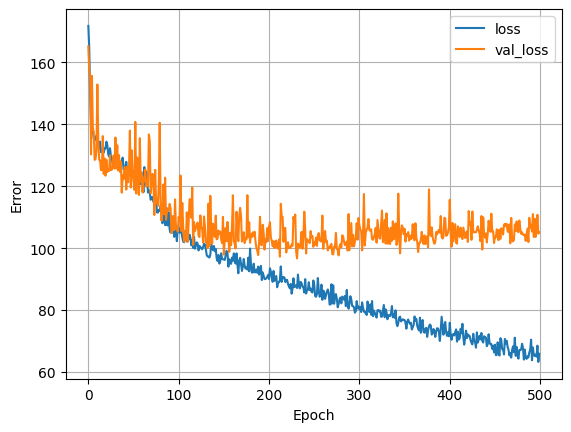

In [88]:
plot_loss(history)

43/43 [==============================] - 0s 564us/step


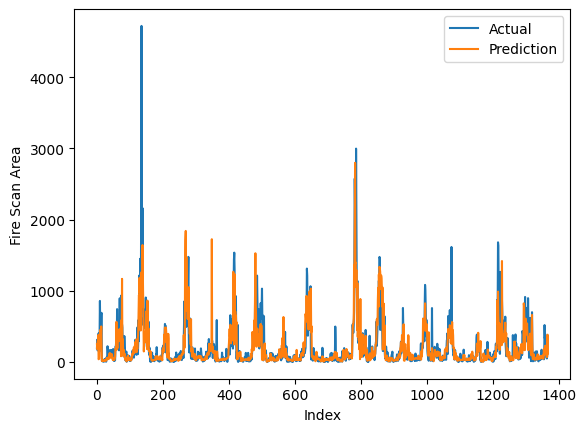

In [89]:
plt.plot(test_labels.reset_index()['scan'], label="Actual")
plt.plot(model.predict(test_features), label="Prediction")
plt.xlabel("Index")
plt.ylabel("Fire Scan Area")
plt.legend()

In [93]:
model.save("../model/model.h5")

model

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Testing to see if loading models works.

43/43 [==============================] - 0s 778us/step


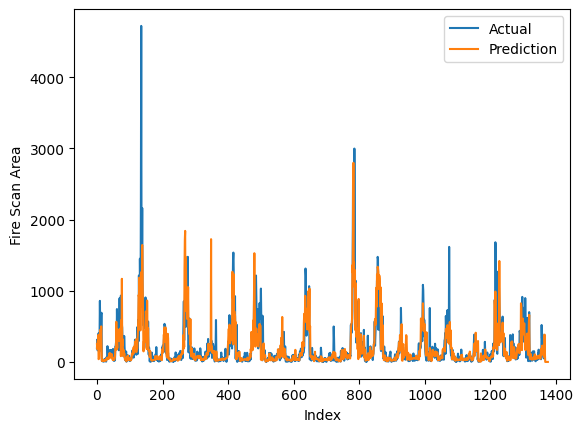

In [94]:
loaded_model = tf.keras.models.load_model("../model/model.h5")

predictions = loaded_model.predict(test_features).to_tensor().numpy().flatten()

plt.plot(test_labels.reset_index()['scan'], label="Actual")
plt.plot(predictions, label="Prediction")
plt.xlabel("Index")
plt.ylabel("Fire Scan Area")
plt.legend()